In [18]:
import os
import sys
from pathlib import Path

import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange
import cv2
import seaborn as sns

In [19]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [20]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import transform 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
experiment = "endometrium"
core = "L11"
datasets = [
    core + "_1",
    core + "_2",
    core + "_3",
    core + "_4",
    core + "_5",
    core + "_6",
]

# Get images

In [22]:
from functools import partial

import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries
from skimage.transform import rotate
from sklearn.preprocessing import MinMaxScaler

h5_data_dir = p_dir / "data" / "h5"


def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs, labels


def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (0, 100))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale


# Read mask image
def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

def crop_img(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"]
    rotation_small = info["rotation_adjust"]
    border = info["border"]

    img = rotate(img, rotation, resize=True)
    img = cv2.copyMakeBorder(
        img, border, border, border, border, cv2.BORDER_CONSTANT, None, value=0
    )
    img = contrast_stretching(img)
    
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]
        img = rotate(img, rotation_small, resize=True)
        
    if "affine" in info.keys():
        aff = info["affine"]
        pad = info["pad"]
        y = y - pad
        h_region = h_region + 2*pad
        x = x - pad
        w_region = w_region + 2*pad
        y = 0 if y < 0 else y
        x = 0 if x < 0 else x
        img_aff = img[y : y + h_region, x : x + w_region]
        img = transform.apply_global_affine(img_aff, img_aff, aff)
        y, h_region, x, w_region = info["bbox_aff"]
        
    img = img[y : y + h_region, x : x + w_region]
    return img


def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

In [23]:
imgs_imc_all = {}
masks = get_masks(data_dir / "masks", f"{experiment}_{core}")

for dataset in datasets:
    try:
        imgs, markers = get_imgs(f"{dataset}", "IMC")
        imgs_imc_all[f"{experiment}_{dataset}"] = imgs
    except:
        continue

In [24]:
# for dataset in datasets:
#     try:
#         info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
#     except:
#         continue
    
#     imgs_imc = imgs_imc_all["_".join([experiment, dataset])]


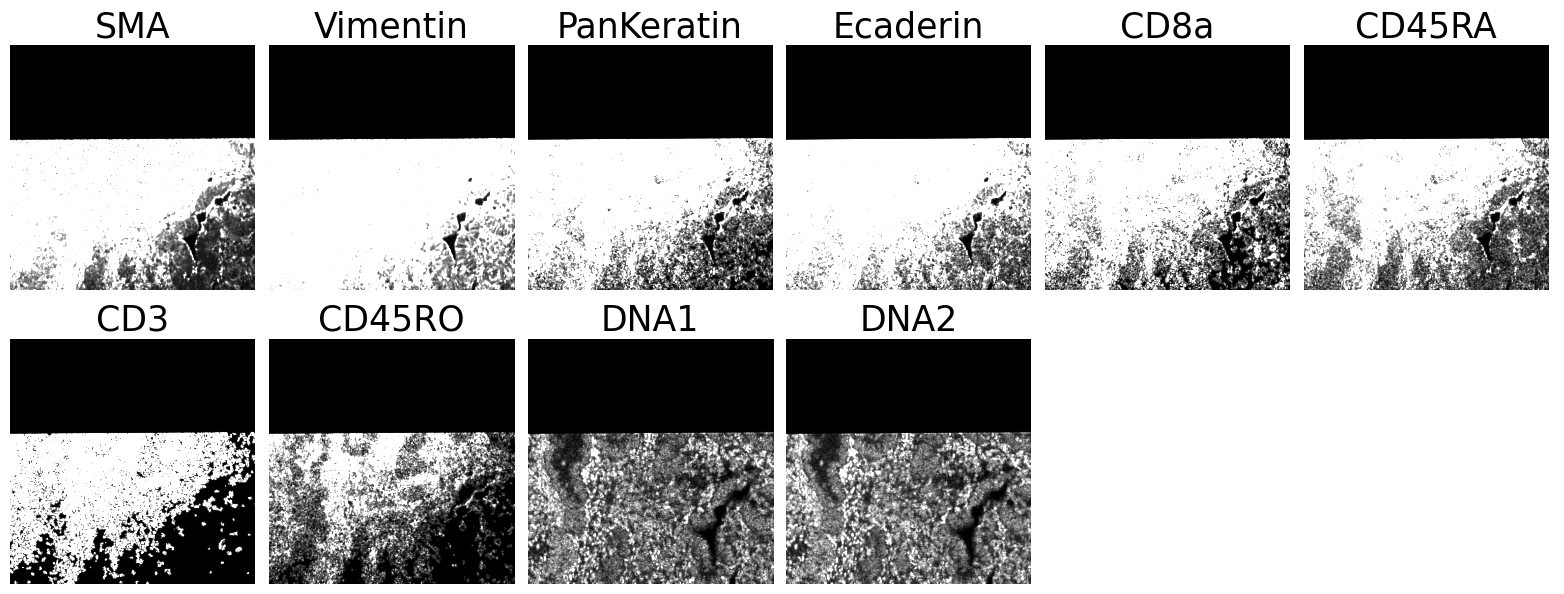

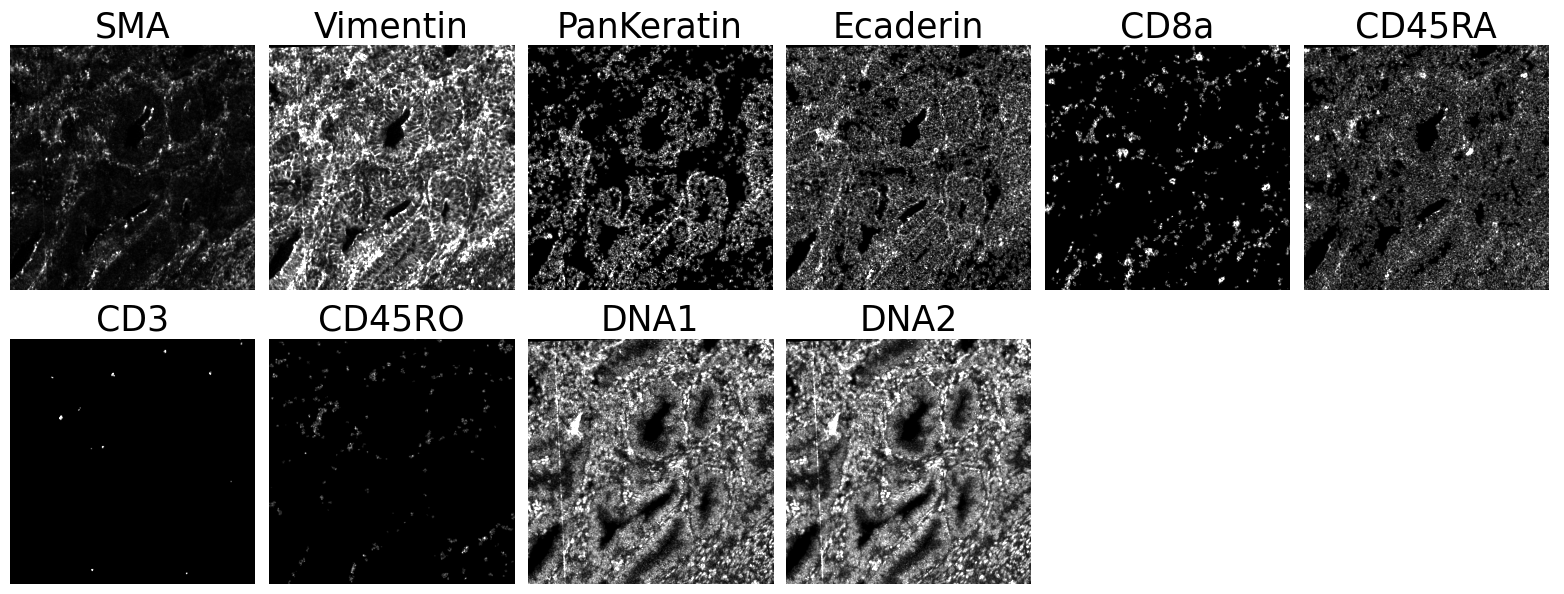

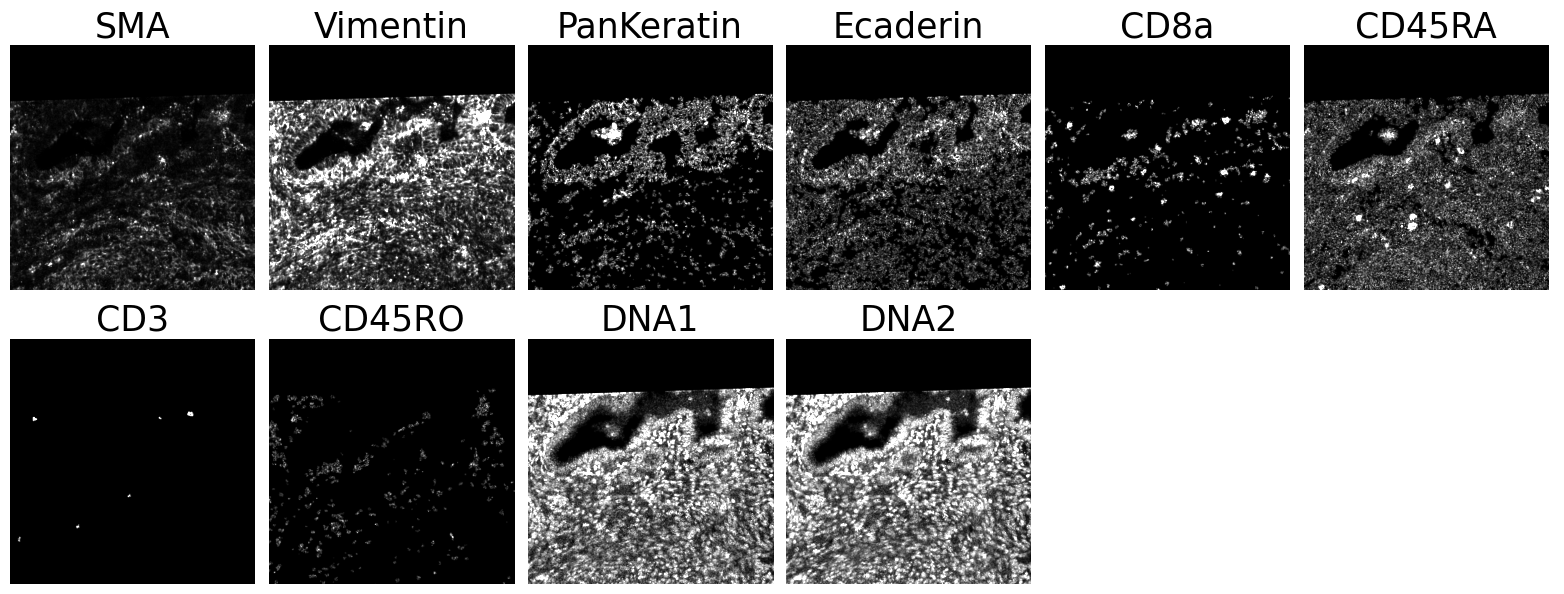

In [28]:
for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    # imgs_imc, markers = get_imgs(f"{dataset}", "IMC")
    imgs_imc, markers = get_imgs(f"{core}", "IMC")
    
    # ---- Load IMC image
    imgs =  [crop_img(img, info) for img in imgs_imc]
    mask = masks["_".join([experiment, dataset])]
    
    fig, ax = plt.subplots(2, 6, figsize=(20,7))
    ax = ax.flatten()
    for i, ax in enumerate(ax):
        try:
            ax.imshow(imgs[i], cmap='gray', interpolation=None, vmax=100)
            ax.set_title(f'{markers[i]}', fontsize=25)
        except:
                
            pass
        ax.axis('off')
    fig.subplots_adjust(wspace=0.01)
    plt.show()

In [32]:
# import napari
# napari.view_image(np.stack(imgs_imc), channel_axis=0, name=markers, visible=False)

# Plot registration

In [42]:
from typing import List
from skimage import measure
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from functools import partial
import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries
from skimage.transform import rotate
from skimage.filters import threshold_otsu
import matplotlib.offsetbox
from matplotlib.lines import Line2D

h5_data_dir = p_dir / "data" / "h5"

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, textprops={}, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, textprops=textprops)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

def get_contour(mask: np.ndarray):
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

def get_imgs_index(imgs, index_list, fov_dim):

    imgs_subset = imgs[index_list, :, :]
    img_combined = np.sum(imgs_subset, axis=0)
    img_downscale = resize(img_combined, (fov_dim, fov_dim), anti_aliasing=False)
    return img_downscale

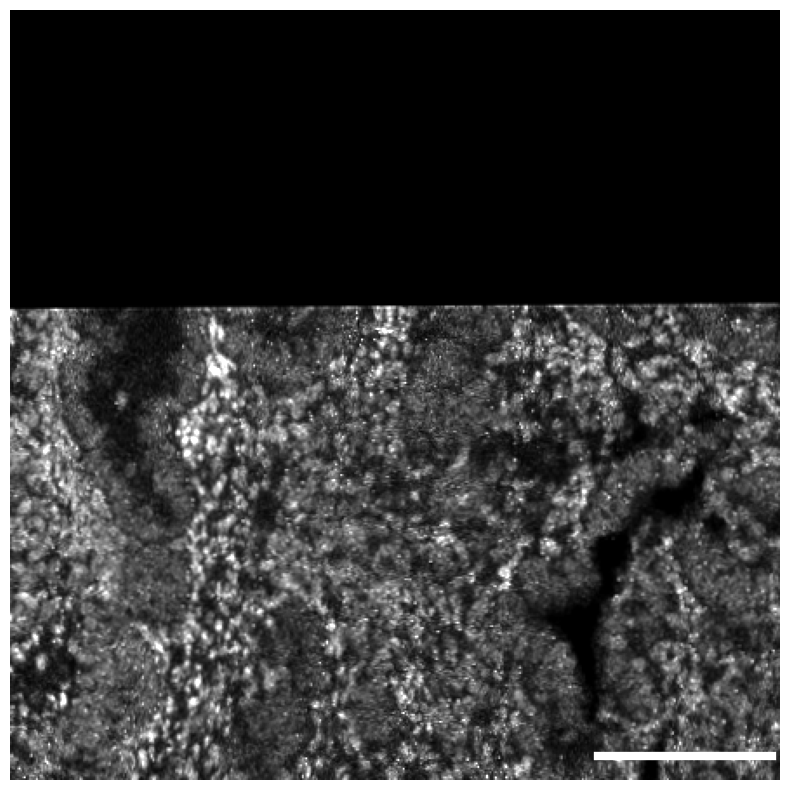

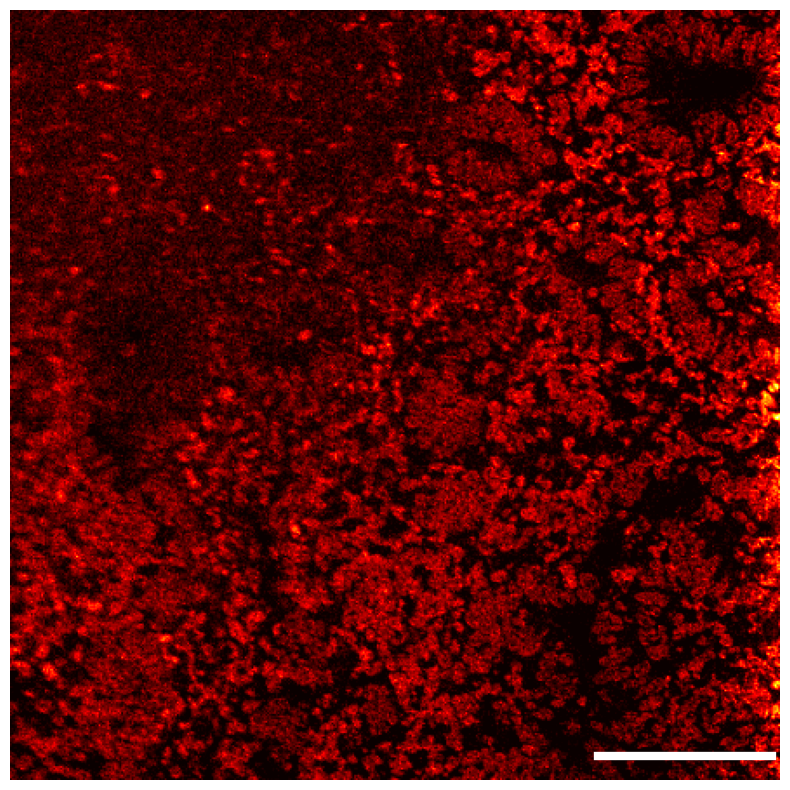

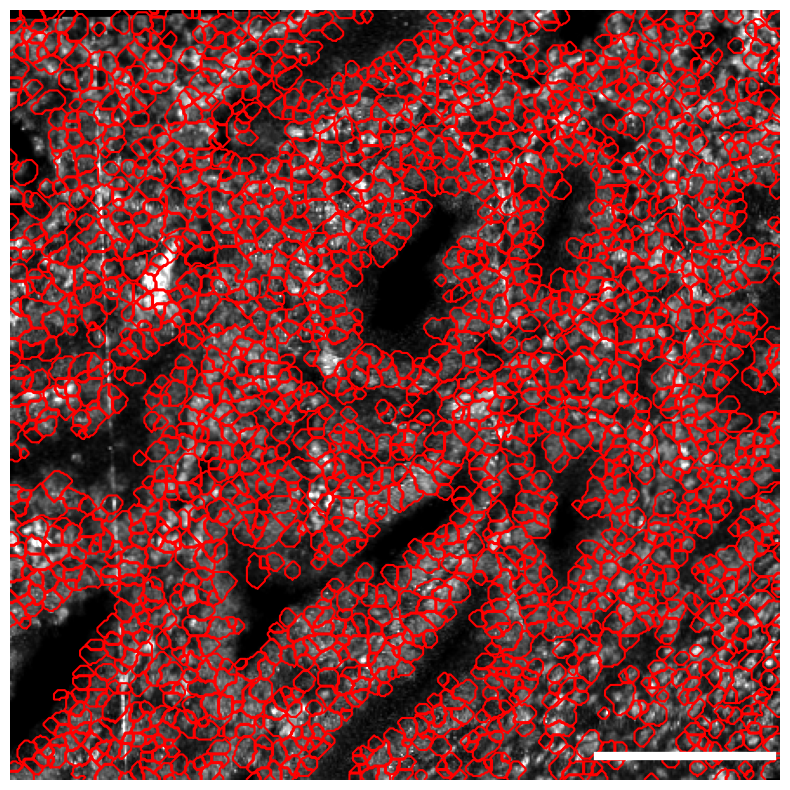

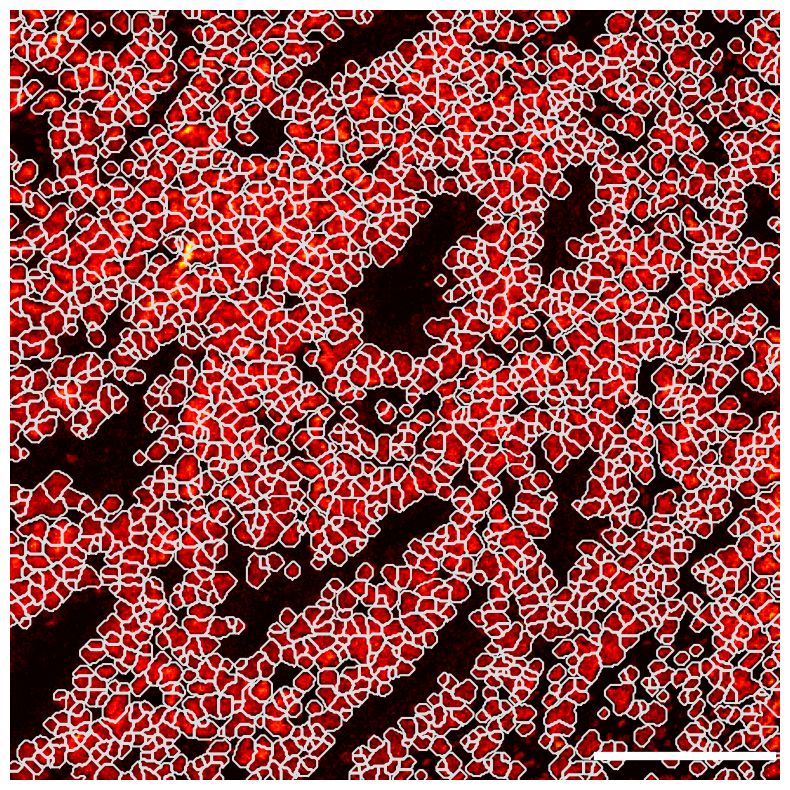

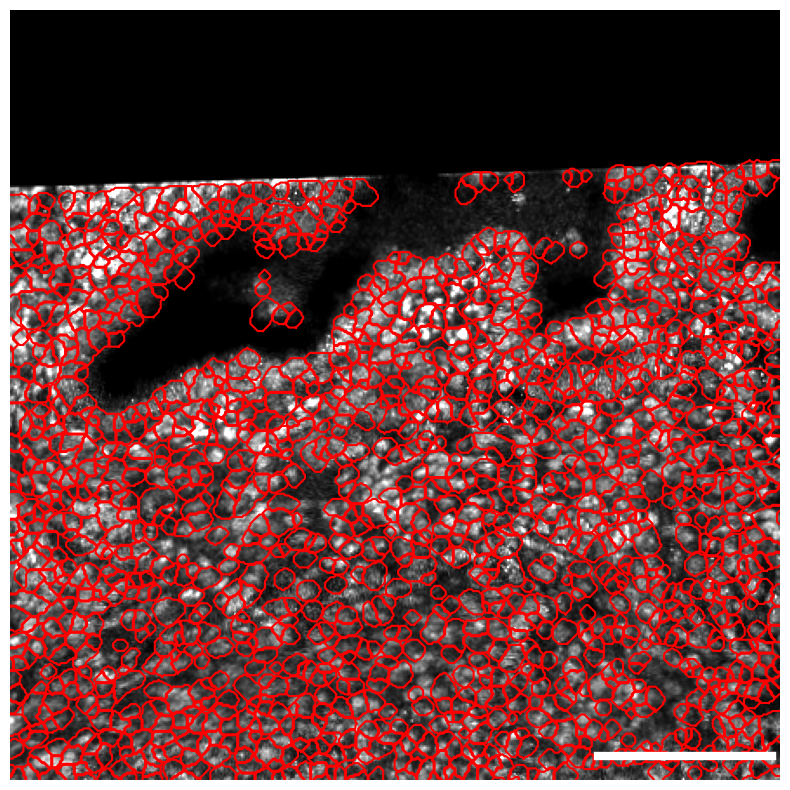

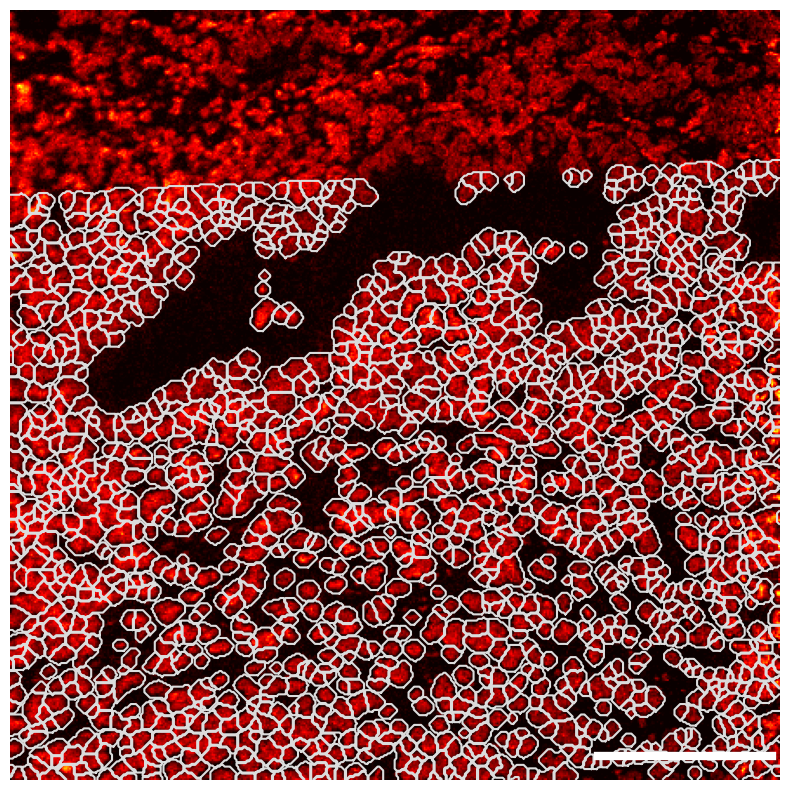

In [43]:
subset = ["DNA1",  "DNA2"]

for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    # imgs_imc, markers = get_imgs(f"{dataset}", "IMC")
    imgs_imc, markers = get_imgs(f"{core}", "IMC")
    
    # ---- Load IMC image
    imgs_imc_stack = np.stack(imgs_imc)
    img_dapi = np.sum(imgs_imc_stack[[markers.index(marker) for marker in subset]], axis=0)
    img_dapi = contrast_stretching(img_dapi)
    img = crop_img(img_dapi, info)
    
    # Get mask and contour
    mask = masks["_".join([experiment, dataset])]
    contours = get_contour(mask)
    
    filename = p_dir / 'figures' / 'segmentation' / f'{dataset}_IMC.png'
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img, vmax=150, cmap="gray")
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color="red")
    ax.axis("off")
    ob = AnchoredHScaleBar(size=100, label="", loc=4, frameon=False, extent=0.,
                           pad=0.1,sep=4, linekw=dict(color="w", linewidth=6), textprops=dict(color='w',fontsize=8))
    ax.add_artist(ob)
    fig.savefig(filename,bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()
    
    
    # ---- Load SIMS images
    imgs, labels = get_imgs_sims(experiment, dataset)
    # Read nulcie channel
    img_nuclei_downscale = get_imgs_index(imgs, [18, 32], fov_dim=img.shape[0])
    # Contrast streching
    p2, p98 = np.percentile(img_nuclei_downscale, (10, 100))
    img_nuclei_downscale = exposure.rescale_intensity(
        img_nuclei_downscale, in_range=(p2, p98), out_range=(0, 255)
    )
    img_nuclei_downscale = img_nuclei_downscale.astype(np.uint8)
    
    filename = p_dir / 'figures' / 'segmentation' / f'{dataset}_SIMS.png'
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_nuclei_downscale, cmap="hot")
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color="gainsboro")
    ax.axis("off")
    ob = AnchoredHScaleBar(size=100, label="", loc=4, frameon=False, extent=0.,
                           pad=0.1,sep=4, linekw=dict(color="w", linewidth=6), textprops=dict(color='w',fontsize=8))
    ax.add_artist(ob)
    fig.savefig(filename,bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()